<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 570, '日付': '2021-04-10T08:00:00.000Z'},
 {'小計': 421, '日付': '2021-04-11T08:00:00.000Z'},
 {'小計': 306, '日付': '2021-04-12T08:00:00.000Z'},
 {'小計': 510, '日付': '2021-04-13T08:00:00.000Z'},
 {'小計': 591, '日付': '2021-04-14T08:00:00.000Z'},
 {'小計': 729, '日付': '2021-04-15T08:00:00.000Z'},
 {'小計': 667, '日付': '2021-04-16T08:00:00.000Z'},
 {'小計': 759, '日付': '2021-04-17T08:00:00.000Z'},
 {'小計': 543, '日付': '2021-04-18T08:00:00.000Z'},
 {'小計': 405, '日付': '2021-04-19T08:00:00.000Z'},
 {'小計': 711, '日付': '2021-04-20T08:00:00.000Z'},
 {'小計': 843, '日付': '2021-04-21T08:00:00.000Z'},
 {'小計': 861, '日付': '2021-04-22T08:00:00.000Z'},
 {'小計': 759, '日付': '2021-04-23T08:00:00.000Z'},
 {'小計': 876, '日付': '2021-04-24T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-04-20 17:00:00+09:00,447,0,711,2021-04-20 17:00:00+09:00
2021-04-21 17:00:00+09:00,551,0,843,2021-04-21 17:00:00+09:00
2021-04-22 17:00:00+09:00,519,0,861,2021-04-22 17:00:00+09:00
2021-04-23 17:00:00+09:00,0,0,759,2021-04-23 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-04-20 17:00:00+09:00,447,0,711,2021-04-20 17:00:00+09:00,436.285714,3054.0,0.0,0.0,629.285714,4405.0
2021-04-21 17:00:00+09:00,551,0,843,2021-04-21 17:00:00+09:00,453.857143,3177.0,0.0,0.0,665.285714,4657.0
2021-04-22 17:00:00+09:00,519,0,861,2021-04-22 17:00:00+09:00,471.285714,3299.0,0.0,0.0,684.142857,4789.0
2021-04-23 17:00:00+09:00,0,0,759,2021-04-23 17:00:00+09:00,405.714286,2840.0,0.0,0.0,697.285714,4881.0
2021-04-24 17:00:00+09:00,0,0,876,2021-04-24 17:00:00+09:00,338.571429,2370.0,0.0,0.0,714.000000,4998.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-04-10 17:00:00+09:00,381,0,570,2021-04-10 17:00:00+09:00,354.714286,2483.0,0.0,0.0,458.571429,3210.0,'21w14,Sat
2021-04-11 17:00:00+09:00,315,0,421,2021-04-11 17:00:00+09:00,350.571429,2454.0,0.0,0.0,468.000000,3276.0,'21w14,Sun
2021-04-12 17:00:00+09:00,412,0,306,2021-04-12 17:00:00+09:00,362.142857,2535.0,0.0,0.0,476.142857,3333.0,'21w15,Mon
2021-04-13 17:00:00+09:00,409,0,510,2021-04-13 17:00:00+09:00,372.714286,2609.0,0.0,0.0,492.000000,3444.0,'21w15,Tue
2021-04-14 17:00:00+09:00,428,0,591,2021-04-14 17:00:00+09:00,387.285714,2711.0,0.0,0.0,497.142857,3480.0,'21w15,Wed
2021-04-15 17:00:00+09:00,397,0,729,2021-04-15 17:00:00+09:00,390.285714,2732.0,0.0,0.0,523.428571,3664.0,'21w15,Thu
2021-04-16 17:00:00+09:00,459,0,667,2021-04-16 17:00:00+09:00,400.142857,2801.0,0.0,0.0,542.000000,3794.0,'21w15,Fri
2021-04-17 17:00:00+09:00,470,0,759,2021-04-17 17:00:00+09:00,412.857143,2890.0,0.0,0.0,569.000000,3983.0,'21w15,Sat
2021-04-18 17:00:00+09:00,398,0,543,2021-04-18 17:00:00+09:00,424.714286,2973.0,0.0,0.0,586.428571,4105.0,'21w15,Sun
2021-04-19 17:00:00+09:00,455,0,405,2021-04-19 17:00:00+09:00,430.857143,3016.0,0.0,0.0,600.571429,4204.0,'21w16,Mon


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-04-04 17:00:00+09:00,389.714286,2728
2021-04-11 17:00:00+09:00,468.000000,3276
2021-04-18 17:00:00+09:00,586.428571,4105
2021-04-24 17:00:00+09:00,742.500000,4455
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-04-10 17:00:00+09:00,381,0,570,2021-04-10 17:00:00+09:00,354.714286,2483.0,0.0,0.0,458.571429,3210.0,'21w14,Sat,NaN,NaN
2021-04-11 17:00:00+09:00,315,0,421,2021-04-11 17:00:00+09:00,350.571429,2454.0,0.0,0.0,468.000000,3276.0,'21w14,Sun,468.000000,3276.0
2021-04-12 17:00:00+09:00,412,0,306,2021-04-12 17:00:00+09:00,362.142857,2535.0,0.0,0.0,476.142857,3333.0,'21w15,Mon,NaN,NaN
2021-04-13 17:00:00+09:00,409,0,510,2021-04-13 17:00:00+09:00,372.714286,2609.0,0.0,0.0,492.000000,3444.0,'21w15,Tue,NaN,NaN
2021-04-14 17:00:00+09:00,428,0,591,2021-04-14 17:00:00+09:00,387.285714,2711.0,0.0,0.0,497.142857,3480.0,'21w15,Wed,NaN,NaN
2021-04-15 17:00:00+09:00,397,0,729,2021-04-15 17:00:00+09:00,390.285714,2732.0,0.0,0.0,523.428571,3664.0,'21w15,Thu,NaN,NaN
2021-04-16 17:00:00+09:00,459,0,667,2021-04-16 17:00:00+09:00,400.142857,2801.0,0.0,0.0,542.000000,3794.0,'21w15,Fri,NaN,NaN
2021-04-17 17:00:00+09:00,470,0,759,2021-04-17 17:00:00+09:00,412.857143,2890.0,0.0,0.0,569.000000,3983.0,'21w15,Sat,NaN,NaN
2021-04-18 17:00:00+09:00,398,0,543,2021-04-18 17:00:00+09:00,424.714286,2973.0,0.0,0.0,586.428571,4105.0,'21w15,Sun,586.428571,4105.0
2021-04-19 17:00:00+09:00,455,0,405,2021-04-19 17:00:00+09:00,430.857143,3016.0,0.0,0.0,600.571429,4204.0,'21w16,Mon,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

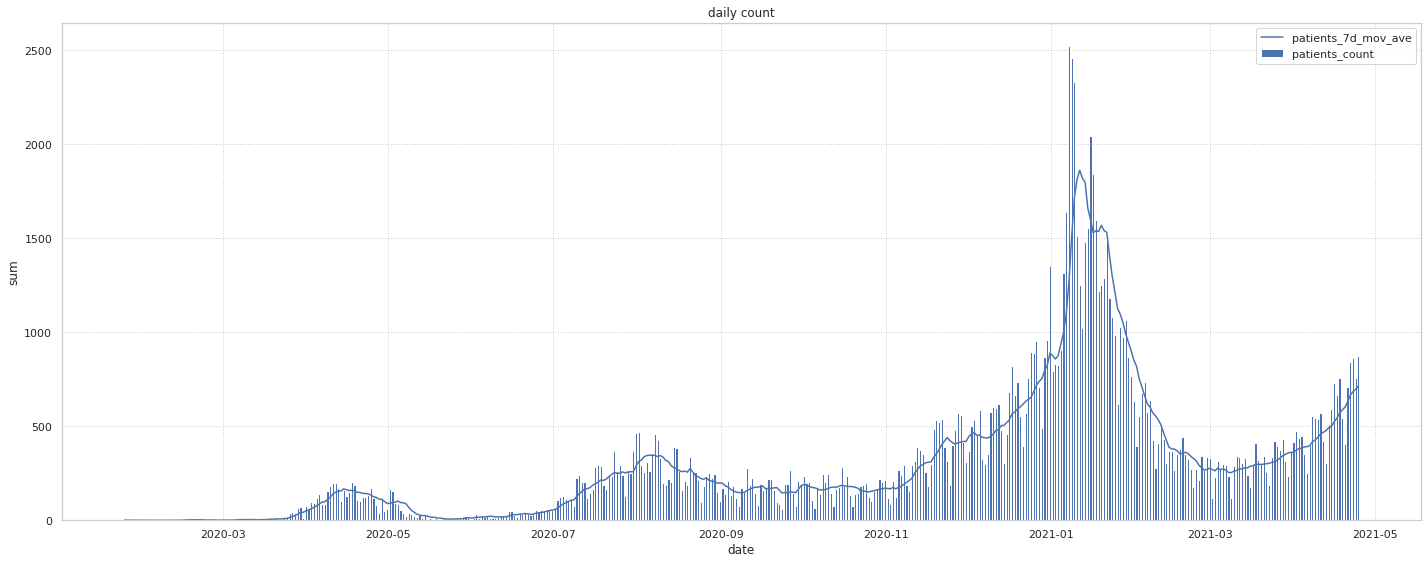

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
442,1.618042e+09,2021,4,10,0,0,1,0,0,0,0,442,0,368,381,354.714286,2483.0,0,0.0,0.0,570,458.571429,3210.0
443,1.618128e+09,2021,4,11,0,0,0,1,0,0,0,443,0,369,315,350.571429,2454.0,0,0.0,0.0,421,468.000000,3276.0
444,1.618214e+09,2021,4,12,0,1,0,0,0,0,0,444,0,370,412,362.142857,2535.0,0,0.0,0.0,306,476.142857,3333.0
445,1.618301e+09,2021,4,13,0,0,0,0,0,1,0,445,0,371,409,372.714286,2609.0,0,0.0,0.0,510,492.000000,3444.0
446,1.618387e+09,2021,4,14,0,0,0,0,0,0,1,446,0,372,428,387.285714,2711.0,0,0.0,0.0,591,497.142857,3480.0
447,1.618474e+09,2021,4,15,0,0,0,0,1,0,0,447,0,373,397,390.285714,2732.0,0,0.0,0.0,729,523.428571,3664.0
448,1.618560e+09,2021,4,16,1,0,0,0,0,0,0,448,0,374,459,400.142857,2801.0,0,0.0,0.0,667,542.000000,3794.0
449,1.618646e+09,2021,4,17,0,0,1,0,0,0,0,449,0,375,470,412.857143,2890.0,0,0.0,0.0,759,569.000000,3983.0
450,1.618733e+09,2021,4,18,0,0,0,1,0,0,0,450,0,376,398,424.714286,2973.0,0,0.0,0.0,543,586.428571,4105.0
451,1.618819e+09,2021,4,19,0,1,0,0,0,0,0,451,0,377,455,430.857143,3016.0,0,0.0,0.0,405,600.571429,4204.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            457 non-null    float64
 1   year                 457 non-null    int64  
 2   month                457 non-null    int64  
 3   day                  457 non-null    int64  
 4   Fri                  457 non-null    uint8  
 5   Mon                  457 non-null    uint8  
 6   Sat                  457 non-null    uint8  
 7   Sun                  457 non-null    uint8  
 8   Thu                  457 non-null    uint8  
 9   Tue                  457 non-null    uint8  
 10  Wed                  457 non-null    uint8  
 11  passed               457 non-null    int64  
 12  emergency            457 non-null    int64  
 13  em_passed            457 non-null    int64  
 14  contacts_count       457 non-null    int64  
 15  contacts_7d_mov_ave  457 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.570000e+02,457.000000,457.000000,457.000000,457.00000,457.000000,457.00000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,1.599552e+09,2020.249453,5.770241,15.730853,0.14442,0.142232,0.14442,0.142232,0.142232,0.142232,0.142232,228.000000,0.107221,160.072210,676.905908,675.319735,4727.229759,806.387309,806.387309,5644.711160,294.393873,289.131385,2023.884026
std,1.141074e+07,0.433171,3.458677,8.800904,0.35190,0.349671,0.35190,0.349671,0.349671,0.349671,0.349671,132.068795,0.309733,123.404312,454.351618,441.118124,3087.839668,879.113312,781.310957,5469.176702,366.245840,344.628014,2412.426028
min,1.579853e+09,2020.000000,1.000000,1.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.589702e+09,2020.000000,3.000000,8.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,114.000000,0.000000,40.000000,378.000000,379.000000,2653.000000,0.000000,0.000000,0.000000,47.000000,43.000000,301.000000
50%,1.599552e+09,2020.000000,5.000000,16.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,228.000000,0.000000,154.000000,529.000000,549.428571,3846.000000,548.000000,911.571429,6381.000000,193.000000,180.000000,1260.000000
75%,1.609402e+09,2020.000000,9.000000,23.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,342.000000,0.000000,268.000000,810.000000,817.000000,5719.000000,1420.000000,1401.857143,9813.000000,371.000000,361.571429,2531.000000
max,1.619251e+09,2021.000000,12.000000,31.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,456.000000,1.000000,382.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.749454,0.127378,-0.006370,-0.001557,-0.003087,0.001557,-0.006173,0.006173,7.678094e-19,0.003087,1.000000e+00,-0.341497,0.994164,-0.292372,-0.272495,-0.272489,-0.478926,-0.515381,-0.515381,0.598100,0.628278,0.628295
year,7.494539e-01,1.000000,-0.558870,-0.054830,0.007713,-0.003105,0.007713,-0.003105,-0.003105,-3.104752e-03,-0.003105,7.494539e-01,-0.199790,0.773676,-0.277018,-0.250034,-0.250031,-0.529395,-0.595663,-0.595663,0.562115,0.613305,0.613306
month,1.273782e-01,-0.558870,1.000000,-0.009096,-0.014119,0.001694,-0.010515,-0.003746,0.012574,5.320820e-03,0.008947,1.273782e-01,-0.126391,0.083388,0.051895,0.035837,0.035841,0.195623,0.250940,0.250940,-0.096307,-0.136497,-0.136475
day,-6.369570e-03,-0.054830,-0.009096,1.000000,0.006914,-0.010337,0.009746,0.007478,-0.001785,-7.486248e-03,-0.004636,-6.369570e-03,-0.001458,-0.005014,-0.013053,-0.008411,-0.008415,0.010681,-0.005232,-0.005232,-0.003340,0.006282,0.006266
Fri,-1.557145e-03,0.007713,-0.014119,0.006914,1.000000,-0.167300,-0.168798,-0.167300,-0.167300,-1.673005e-01,-0.167300,-1.557145e-03,-0.001541,-0.000241,-0.024439,-0.005352,-0.005351,0.034596,-0.004594,-0.004594,0.050366,0.000231,0.000221
Mon,-3.086662e-03,-0.003105,0.001694,-0.010337,-0.167300,1.000000,-0.167300,-0.165816,-0.165816,-1.658163e-01,-0.165816,-3.086662e-03,0.000620,-0.003237,0.041839,0.001134,0.001135,0.155555,0.001849,0.001849,-0.121059,-0.002769,-0.002767
Sat,1.557145e-03,0.007713,-0.010515,0.009746,-0.168798,-0.167300,1.000000,-0.167300,-0.167300,-1.673005e-01,-0.167300,1.557145e-03,-0.001541,0.002537,0.038791,-0.005352,-0.005351,-0.180619,-0.004594,-0.004594,0.060779,0.002491,0.002484
Sun,-6.173324e-03,-0.003105,-0.003746,0.007478,-0.167300,-0.165816,-0.167300,1.000000,-0.165816,-1.658163e-01,-0.165816,-6.173324e-03,0.000620,-0.005981,-0.014768,0.000210,0.000211,-0.162042,0.001849,0.001849,-0.041587,-0.003819,-0.003820
Thu,6.173324e-03,-0.003105,0.012574,-0.001785,-0.167300,-0.165816,-0.167300,-0.165816,1.000000,-1.658163e-01,-0.165816,6.173324e-03,0.000620,0.005098,-0.007259,0.004216,0.004217,0.046548,0.001849,0.001849,0.080369,0.003505,0.003511
Tue,7.678094e-19,-0.003105,0.005321,-0.007486,-0.167300,-0.165816,-0.167300,-0.165816,-0.165816,1.000000e+00,-0.165816,-2.361914e-18,0.000620,-0.000493,-0.022374,0.002042,0.002043,0.063049,0.001849,0.001849,-0.037871,-0.000923,-0.000919


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1.618906e+09,0,0,0,0,0,1,0,452,0,378,447,0,711,629.285714,4405.0
453,1.618992e+09,0,0,0,0,0,0,1,453,0,379,551,0,843,665.285714,4657.0
454,1.619078e+09,0,0,0,0,1,0,0,454,0,380,519,0,861,684.142857,4789.0
455,1.619165e+09,1,0,0,0,0,0,0,455,0,381,0,0,759,697.285714,4881.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
452,1.618906e+09,452,0,711,629.285714,4405.0
453,1.618992e+09,453,0,843,665.285714,4657.0
454,1.619078e+09,454,0,861,684.142857,4789.0
455,1.619165e+09,455,0,759,697.285714,4881.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

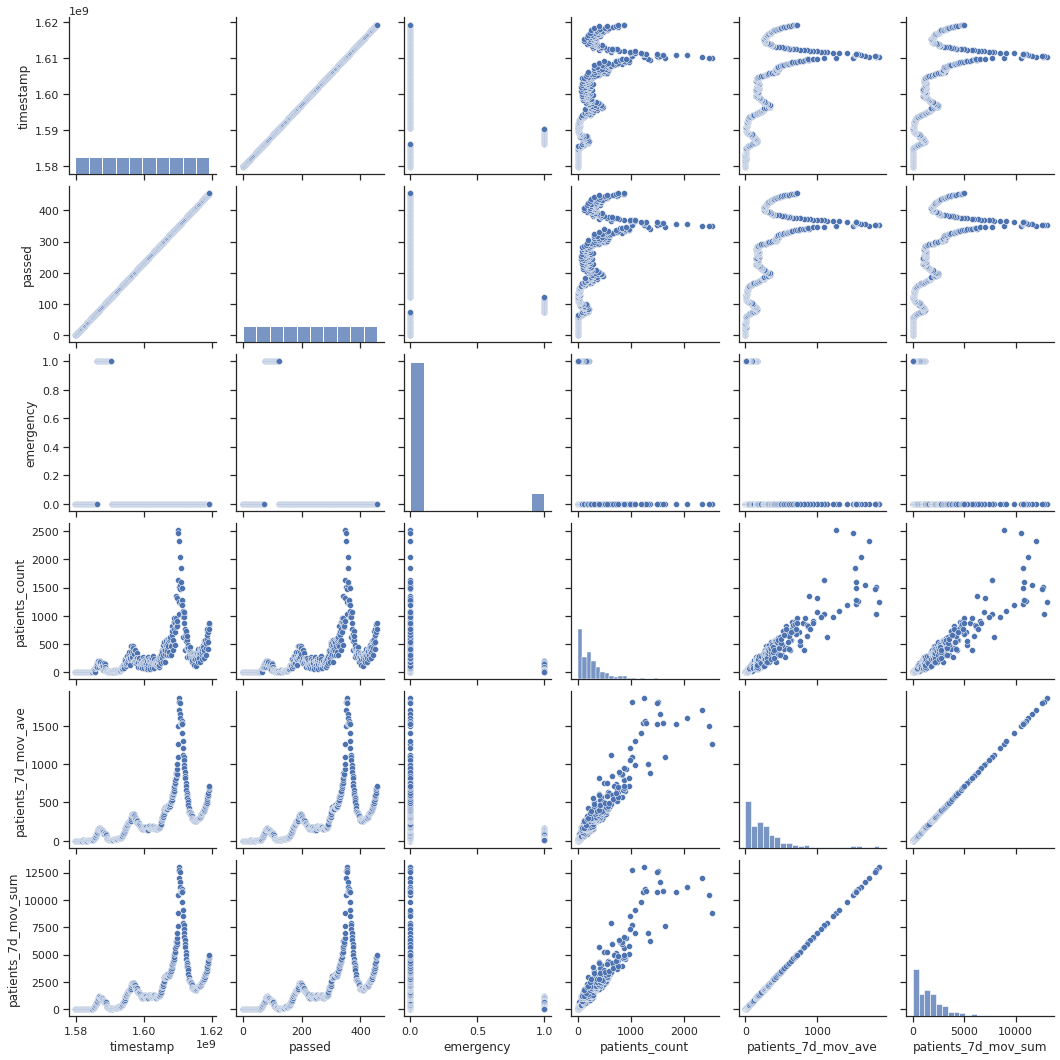

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
